# Paper figure: Cloned model comparison

March 2022

gully


The goal of the notebook is to make a figure for the paper showing how we clone the precomputed synthetic model.

In [1]:
%config Completer.use_jedi = False

In [2]:
import torch
from blase.emulator import PhoenixEmulator, SparsePhoenixEmulator
import matplotlib.pyplot as plt
from gollum.phoenix import PHOENIXSpectrum
import numpy as np
from tqdm.notebook import tqdm
import os

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
    
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
device

'cuda'

### Retrieve the Phoenix model

In [4]:
spectrum = PHOENIXSpectrum(teff=4100, logg=3.5)#, wl_lo=8019, wl_hi=12845)
spectrum = spectrum.divide_by_blackbody()
spectrum = spectrum.normalize()
continuum_fit = spectrum.fit_continuum(polyorder=5)
spectrum = spectrum.divide(continuum_fit, handle_meta="ff")

In [5]:
# Numpy arrays: 1 x N_pix
wl_native = spectrum.wavelength.value
flux_native = spectrum.flux.value

### Clone the model

In [6]:
emulator = SparsePhoenixEmulator(wl_native, flux_native, prominence=0.01)

Initializing a sparse model with 11759 spectral lines


In [7]:
emulator.to(device)

SparsePhoenixEmulator()

In [8]:
import copy

In [9]:
state_dict_init = copy.deepcopy(emulator.state_dict())

In [10]:
state_dict_init['lam_centers'].shape

torch.Size([11759])

In [11]:
state_dict_post = torch.load('../experiments/06_bare_emulator_clone/emulator_T4100g3p5_prom0p01_HPF_recovery.pt')

In [12]:
emulator_pre = copy.deepcopy(emulator)

In [13]:
emulator_post = copy.deepcopy(emulator)

In [14]:
emulator_post.load_state_dict(state_dict_post)

<All keys matched successfully>

In [15]:
%%time
with torch.no_grad():
    spec_out = emulator_post.forward().cpu().numpy()

CPU times: user 23.5 ms, sys: 0 ns, total: 23.5 ms
Wall time: 22.4 ms


In [16]:
import seaborn as sns

In [17]:
sns.set_context('paper', font_scale=1.3)

In [18]:
residual = flux_native - spec_out

In [19]:
mask = (wl_native > 8675) &(wl_native < 8700)

In [20]:
mask.sum() / len(wl_native)

0.007379321952818405

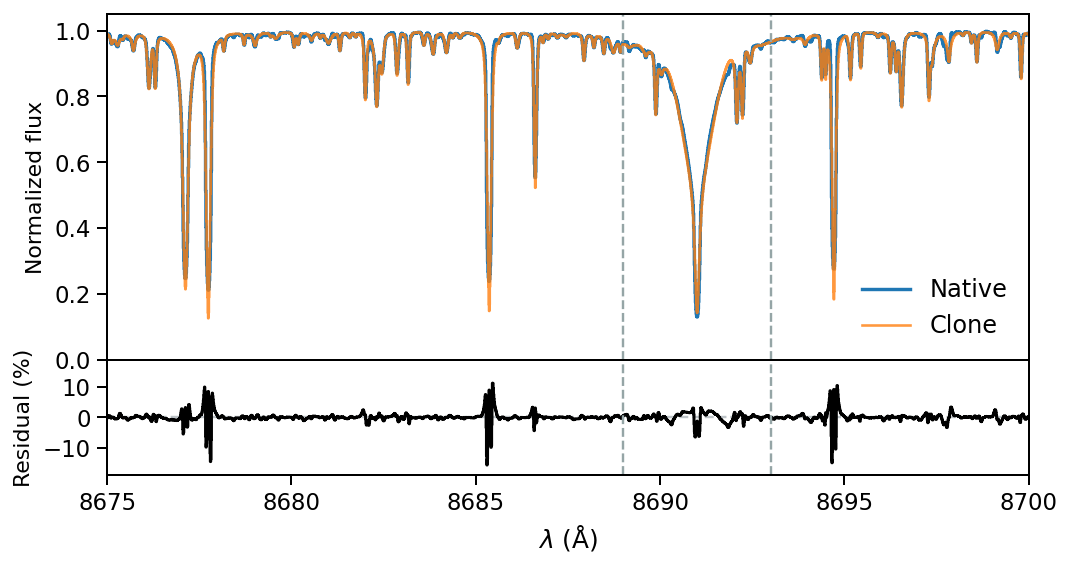

In [21]:
fig = plt.figure(figsize=(8, 4))

# Data - model comparison
ax = fig.add_axes((.1,.3,.8,.6))
ax.set_xticklabels([])
ax.step(wl_native, flux_native, alpha=1, lw=1.7, label='Native')
ax.step(wl_native, spec_out, alpha=0.8, lw=1.3, label='Clone')
ax.set_xlim(8675, 8700)
ax.axvline(8689, linestyle='dashed', color='#95a5a6')
ax.axvline(8693, linestyle='dashed', color='#95a5a6')
ax.legend(fontsize=12, loc='best', ncol=1, frameon=False)
ax.set_ylim(-0.0001, 1.05)

ax.set_ylabel('Normalized flux', fontsize=11);

# Residual plot 
ax2=fig.add_axes((.1,.1,.8,.2))    
ax2.axhline(0, linestyle='dashed', color='#bdc3c7')
ax2.step(wl_native, residual*100, alpha=1, color='k', lw=1.5)
ax2.set_xlim(8675, 8700)
ax2.set_ylim(-19, 19)
ax2.axvline(8689, linestyle='dashed', color='#95a5a6')
ax2.axvline(8693, linestyle='dashed', color='#95a5a6')
ax2.set_ylabel('Residual (%)', fontsize=11)
ax2.set_xlabel(r'$\lambda$ ($\mathrm{\AA}$)')
plt.savefig('../paper/paper1/figures/blase_clone_demo.png', bbox_inches='tight', dpi=300);

All done!

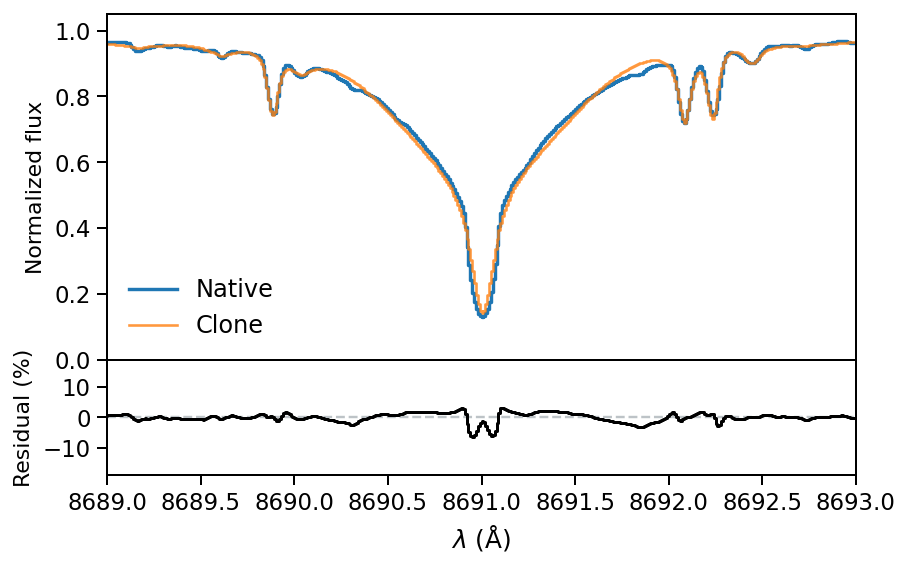

In [22]:
fig = plt.figure(figsize=(6.5, 4))

# Data - model comparison
ax = fig.add_axes((.1,.3,.8,.6))
ax.set_xticklabels([])
ax.step(wl_native, flux_native, alpha=1, lw=1.7, label='Native')
ax.step(wl_native, spec_out, alpha=0.8, lw=1.3, label='Clone')
ax.set_xlim(8689, 8693)
ax.legend(fontsize=12, loc='best', ncol=1, frameon=False)
ax.set_ylim(-0.0001, 1.05)

ax.set_ylabel('Normalized flux', fontsize=11);

# Residual plot 
ax2=fig.add_axes((.1,.1,.8,.2))    
ax2.axhline(0, linestyle='dashed', color='#bdc3c7')
ax2.step(wl_native, residual*100, alpha=1, color='k', lw=1.5)
ax2.set_xlim(8689, 8693)
ax2.set_ylim(-19, 19)
ax2.set_ylabel('Residual (%)', fontsize=11)
ax2.set_xlabel(r'$\lambda$ ($\mathrm{\AA}$)')
plt.savefig('../paper/paper1/figures/blase_clone_demo_zoom.png', bbox_inches='tight', dpi=300);

In [23]:
wl0 = emulator.lam_centers.detach().cpu().numpy()

In [24]:
mask = (wl0 < 8700) & (wl0 >8675)

In [25]:
mask.sum()

73

In [26]:
73/0.007

10428.571428571428